In [5]:
%matplotlib inline

## Question 1

We are given population of beetles at different points in time. We assume that the growth model is logistic.

$$\frac{dN}{dt} = rN\left(1 - \frac{N}{K}\right)$$

where $N$ is population size, $t$ is time, $r$ is a growth rate parameter, and $K$ is a parameter that represents the population carrying capacity of the environment. The solution to this differential equation is given by: 

$$N_t = f(t) = \frac{KN_0}{N_0 + (K - N_0)\exp(-rt)}$$

where $N_t$ denotes the population size at time $t$. 

1) Logistic growth model to the flour beetle data using optimization to minimize the sum of squared errors:

Optimization terminated successfully.
         Current function value: 83240.486583
         Iterations: 99
         Function evaluations: 203


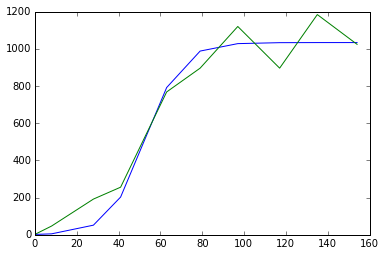

In [80]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

#given data
days = [0,8,28,41,63,79,97,117,135,154]
beetles = [2,47,192,256,768,896,1120,896,1184,1024]

#function to calculate sum of squared errors
def calculateSSE(param):
    k=param[0]
    r=param[1]
    se = [((k*n0/(n0+(k-n0)*np.exp(-r*t)))- x)**2 for x,t in zip(beetles,days)]
    sse = sum(se)
    return sse

n0=2#n at time t=0
initialParam = np.array([1500,0.4])#initialize params
res = minimize(calculateSSE,initialParam,method='nelder-mead',options={'xtol': 1e-8, 'disp': True})#minimize
#read parameters returned
kPred = res.x[0]
rPred = res.x[1]

#do predictions and plot
predictions = [(kPred*n0/(n0+(kPred-n0)*np.exp(-rPred*t))) for x,t in zip(beetles,days)]
plt.plot(days,predictions,c='b')
plt.plot(days,beetles,c='r')



2) The $\log(N_t)$ are independent and normally distributed with mean $\log[f(t)]$ and variance $\sigma^2$. 

So, we have $\log(N_t) \,\sim \, \mathcal{N}(\log(f_t),\sigma^2)$. Since it is required to provide an estimate of standard errors and correlation among the Maximum Likelihood Estimates, we use bootstrapping by generating multiple samples from the given data (by sampling uniformly at random with replacement).

In [92]:
from scipy.stats import norm

def getLikelihood(param):
    #returns the likelihood function that needs to be maximized
    k=param[0]
    r=param[1]
    var=param[2]
    likelihood = -1*np.array([norm.logpdf(np.log(x),loc=np.log((k*n0/(n0+(k-n0)*np.exp(-r*t)))),scale=var)\
                              for x,t in zip(beetles,days)])
    return sum(likelihood)

#initialize variance as the initial variance in the data
var0 = np.var(np.log(np.array(beetles)))

#bootstrap to find 100 sample sets
numBootstrap = 10
sampleSetsDays = np.empty(numBootstrap,dtype=object)
sampleSetsBeetles = np.empty(numBootstrap,dtype=object)
for counter in range(numBootstrap):
    indices = np.random.choice(len(days),len(days))
    sampleSetsDays[counter] = np.take(days,indices)
    sampleSetsBeetles[counter] = np.take(beetles,indices)
    
    
#calculate mle for each of the sets
ks = np.empty(numBootstrap)
rs = np.empty(numBootstrap)
vars = np.empty(numBootstrap)

for counter in range(numBootstrap):
    try:
        beetles = sampleSetsBeetles[counter]
        days = sampleSetsDays[counter]
        initialParam = np.array([1200,0.5,var0])
        result = minimize(getLikelihood,initialParam,method='nelder-mead',options={'xtol': 1e-8, 'disp': False})
        ks[counter] = result.x[0]
        rs[counter] = result.x[1]
        vars[counter] = result.x[2]
#         print(result.x[0])
    except TypeError:
        print("problem in counter " + str (counter))
        
#standard error
varK = np.var(ks)
varR = np.var(rs)
varVars = np.var(vars)
print("Variance in MLE of k is " + str(varK))
print("Varirance in MLE of r is " + str(varR))
print("Variance in MLE of variance is " +str(varVars))


#correlation
corr = np.corrcoef(ks,rs)
print("Correlation coefficient between k and r is " + str(corr[0][1]))
corr = np.corrcoef(ks,vars)
print("Correlation coefficient between k and r is " + str(corr[0][1]))
corr = np.corrcoef(rs,vars)
print("Correlation coefficient between k and r is " + str(corr[0][1]))
       


Variance in MLE of k is 13675.9011037
Varirance in MLE of r is 3.04841160896
Variance in MLE of variance is 0.461463496039
Correlation coefficient between k and r is -0.0242783810191
Correlation coefficient between k and r is 0.164495655649
Correlation coefficient between k and r is 0.161910273873


## Question 2

We implement simulated annealing for minimizing the AIC for the baseball salary regression problem. 

1. Compare the effects of different cooling schedules (different temperatures and different durations at each temperature).

In [93]:
import pandas as pd
from random import randint
from itertools import cycle
import random

#read and prepare data
baseball = pd.read_table("../data/textbook/baseball.dat", sep='\s+')
predictors = baseball.copy()
logsalary = predictors.pop('salary').apply(np.log)
nrows, ncols = predictors.shape

aic = lambda g: g.nobs * np.log((g.resid**2).sum()/g.nobs) + 2*len(g.beta)



In [96]:
def doSimulatedAnnealing(coolingList,taus,neighborhoods):
#     print("inside method")
    aic_values = []
    for cooling in coolingList:# to change cooling schedules
        for tau in taus:#to change tau
            for neighborhood in neighborhoods:#to change neighborhoods
                
                solution_current = solution_best = np.random.binomial(1, 0.5, ncols).astype(bool)
                solution_vars = predictors[predictors.columns[solution_current]]
                g = pd.ols(y=logsalary, x=solution_vars)
                aic_best = aic(g)
                aic_values.append(aic_best)

                for j in range(periods):

                    for i in range(cooling[j]):
                        #randomly change neighborhoods. 
                        flips = np.random.choice(ncols,neighborhood,replace=False)
                        for flip in flips:
                            solution_current[flip] = not solution_current[flip]
                        solution_vars = predictors[predictors.columns[solution_current]]
                        g = pd.ols(y=logsalary, x=solution_vars)
                        aic_step = aic(g)
                        alpha = min(1, np.exp((aic_values[-1] - aic_step)/tau[j]))

                        if ((aic_step < aic_values[-1]) or (np.random.uniform() < alpha)):
                            # Accept proposed solution
                            aic_values.append(aic_step)
                            if aic_step < aic_best:
                                # Replace previous best with this one
                                aic_best = aic_step
                                solution_best = solution_current.copy()
                        else:
                            # Revert solution
                            solution_current[flip] = not solution_current[flip]
                            aic_values.append(aic_values[-1])
                plt.figure(random.randint(1,1000))          
                color=next(colorGenerator)#generate a color for this plot
                print("color for this plot is ")
                plt.plot(aic_values,color=color)
                plt.xlim(0, len(aic_values))
                plt.xlabel('Iteration')
                plt.ylabel('AIC')
                print('Best AIC: {0}\nBest solution: {1}\nDiscovered at iteration {2}'.format(aic_best,
                            np.where(solution_best==True),
                            np.where(aic_values==aic_best)[0][0]))
                plt.plot(np.where(aic_values==aic_best)[0][0], aic_best, color+'o')

color for this plot is b
Best AIC: -416.34832459493106
Best solution: (array([ 1,  2,  3,  5,  7,  9, 11, 12, 13, 14, 15, 24, 25]),)
Discovered at iteration 217
color for this plot is g
Best AIC: -416.09422269660206
Best solution: (array([ 0,  2,  5,  7,  9, 11, 12, 13, 14, 15, 16, 23, 24, 25]),)
Discovered at iteration 3833
color for this plot is r
Best AIC: -415.61030120747597
Best solution: (array([ 1,  2,  5,  7,  8,  9, 11, 12, 13, 14, 15, 19, 24, 25]),)
Discovered at iteration 6117
color for this plot is c
Best AIC: -414.52807796389266
Best solution: (array([ 0,  1,  2,  5,  7,  9, 10, 12, 13, 14, 15, 16, 23, 25]),)
Discovered at iteration 7265


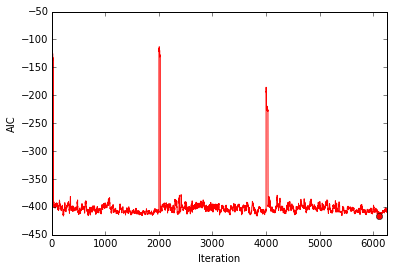

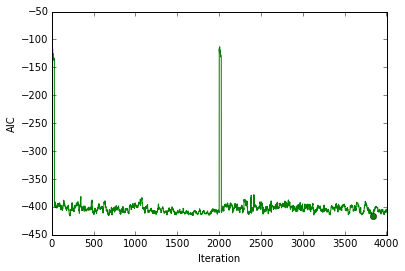

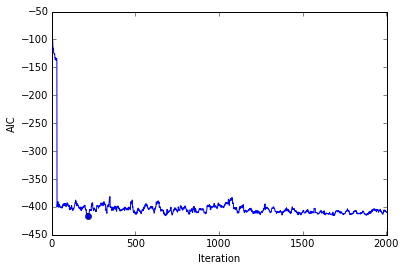

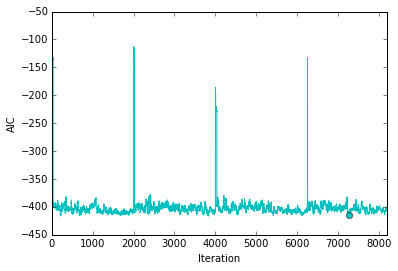

In [97]:
periods = 15
coolingList =[]

colorGenerator = cycle('bgrc')

'''
Initial Set of values
'''
#spend higher time at lower temperatures
coolingList.append([60]*int(periods/3) + [120]*int(periods/3) + [220]*int(periods/3)) 
tau_start = 10
taus = [[tau_start * 0.9**i for i in range(15)]]
neighborhoods = [1]


#Changing Cooling Schedules
#spend higher times at higher temperatures
coolingList.append([220]*int(periods/3) + [120]*int(periods/3) + [60]*int(periods/3)) 
#evenly disributed
coolingList.append([150]*int(periods/3) + [150]*int(periods/3) + [150]*int(periods/3)) 
#randomly chosen times
coolingList.append([randint(50,200) for counter in range(15)]) 

doSimulatedAnnealing(coolingList,taus,neighborhoods)

The four generated plots (can be identified by the colours printed in the outputs) show the following four scenarios: spending greater time at lower temperatures, spending greater time at higher temperatures, spending equal times across temperatures and spending randomly generated times.

We see that spending greater time at lower temperatures (blue plot) finds the lowest AIC value while the worst AIC value is found while using random times at different temperatures(cyan plot). The AIC values are comparable though and do not show much difference based on cooling schedules. Also, spending greater time at lower temperatures causes the least amount of "oscillations" in the AIC plot, thus leading to a more stable run.

color for this plot is b
Best AIC: -417.7431670444301
Best solution: (array([ 1,  2,  7,  9, 12, 13, 14, 15, 23, 24, 26]),)
Discovered at iteration 1781
color for this plot is g
Best AIC: -418.94721143715475
Best solution: (array([ 1,  2,  5,  7,  9, 12, 13, 14, 15, 23, 24, 25]),)
Discovered at iteration 3706
color for this plot is r
Best AIC: -418.94721143715475
Best solution: (array([ 1,  2,  5,  7,  9, 12, 13, 14, 15, 23, 24, 25]),)
Discovered at iteration 3706
color for this plot is c
Best AIC: -416.1566577724648
Best solution: (array([ 2,  7,  9, 11, 12, 13, 14, 15, 19, 21]),)
Discovered at iteration 6193


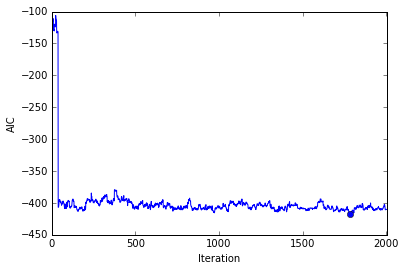

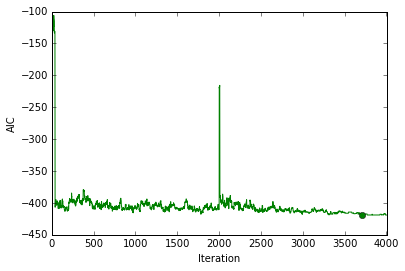

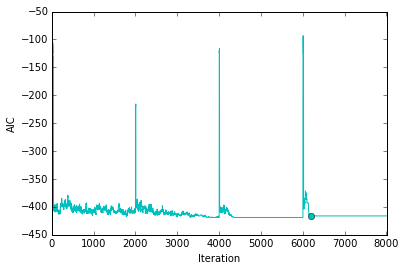

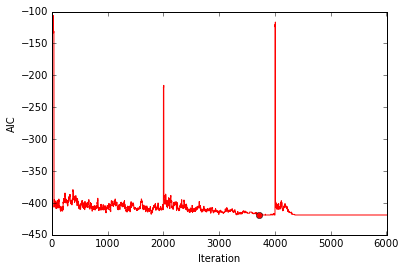

In [98]:
#Change Tau
factors = [0.9,0.8,0.5,0.1]
taus=[]
for factor in factors:
    taus.append([tau_start * factor**i for i in range(15)])
doSimulatedAnnealing([coolingList[0]],taus,neighborhoods)

The four plots above show the effects of the way temperature is varied in simulated annealing. We observe that a gradual lowering of temperature, neither too fast nor too slow, causes the AIC plot to oscillate less than others. The AIC values are comparable but the slow decrease in temperature (by 0.8 factor) causes the least AIC value.

color for this plot is r
Best AIC: -411.1518837259572
Best solution: (array([ 2,  4,  6,  7,  9, 12, 13, 14, 15, 22, 24, 25]),)
Discovered at iteration 1169
color for this plot is c
Best AIC: -410.4440403574973
Best solution: (array([ 2,  5,  6,  7,  8,  9, 10, 12, 13, 14, 17, 19, 20, 21, 23, 25]),)
Discovered at iteration 2192


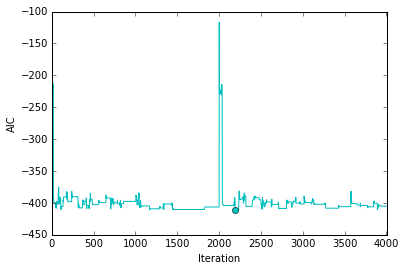

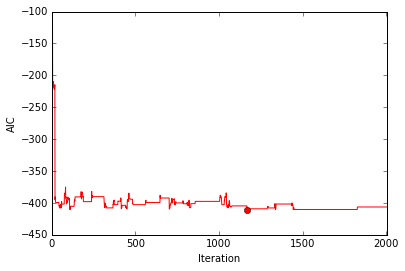

In [100]:
#Changing Neighborhoods
neighborhoods = [2,3]
doSimulatedAnnealing([coolingList[0]],[taus[0]],neighborhoods)

We find that exploring 2-neighborhood provides us a lower AIC value than exploring 3-neighborhood (I checked this by running the code several times). Also, exploring 3-neighborhood causes more variation or "oscillations" in the subsequent AIC values than 2-neighborhoods. This is expected as consecutive candidate solutions are changed more in the latter case.

2) Implement a genetic algorithm for minimizing the AIC for the baseball salary regression problem

In [101]:
aic = lambda g: g.nobs * np.log((g.resid**2).sum()/g.nobs) + 2*len(g.beta)

def calculate_fitness(aic_values):
    P = len(aic_values)
    aic_rank = (-aic_values).argsort().argsort()+1.#relative AIC. only looking at fitness wrt others.
    return 2.*aic_rank/(P*(P+1.))

def doGenericAlgo(mutationRates,generationSizes,eliminateAggresively,change):
    #print("inside method")
    for mutation_rate in mutationRates:
        for pop_size in generationSizes:
            # Initialize genotype
            current_gen = np.random.binomial(1, 0.5, pop_size*ncols).reshape((pop_size, ncols))

            aic_best = []
            best_solution = []
            aic_history = []

            for i in range(iterations):

                # Get phenotype
                current_phe = [predictors[predictors.columns[g.astype(bool)]] for g in current_gen]
                # Calculate AIC
                current_aic = np.array([aic(pd.ols(y=logsalary, x=x)) for x in current_phe])
                # Get lowest AIC
                aic_best.append(current_aic[np.argmin(current_aic)])
                best_solution.append(current_gen[np.argmin(current_aic)])

                # Calculate fitness according to AIC rank
                fitness = calculate_fitness(current_aic)

                # Choose first parents according to fitness
                moms = np.random.choice(range(pop_size), size=int(pop_size/2), p=fitness)
                # Choose second parents randomly
                if not eliminateAggresively:                    
                    dads = np.random.choice(range(pop_size), size=int(pop_size/2))
                else:
                    #eliminating aggresively
                    dads = np.random.choice(range(pop_size), size=int(pop_size/2), p=fitness)



                next_gen = []
                for x,y in zip(current_gen[moms], current_gen[dads]):
                    # Crossover
                    cross = np.random.randint(0, ncols)
                    child1 = np.r_[x[:cross], y[cross:]]
                    child2 = np.r_[y[:cross], x[cross:]]
                    # Mutate
                    m1 = np.random.binomial(1, mutation_rate, size=ncols).astype(bool)
                    child1[m1] = abs(child1[m1]-1)
                    m2 = np.random.binomial(1, mutation_rate, size=ncols)
                    child2[m2] = abs(child1[m2]-1)
                    next_gen += [child1, child2]

                # Increment generation
                current_gen = np.array(next_gen)
                # Store AIC values
                aic_history.append(current_aic)
                
            plt.figure(random.randint(1,1000))
            col = next(colorGenerator)
            if change == "mutation":
                legendLabel = "Mutation rate : " + str(mutation_rate)            
                plt.plot(aic_best,color=col,label=str(mutation_rate))
            elif change == "pop":
                legendLabel = "Pop Size : " + str(pop_size)            
                plt.plot(aic_best,color=col,label=str(pop_size))
            elif change == "fitness":
                #legendLabel = "Fitness : " + str(pop)            
                plt.plot(aic_best,color=col)
                
                
            #pltHandles.append(mpatches.Patch(color=col, label=legendLabel, height = 0.1))
            #plt.legend(handles=pltHandles)
            plt.plot(np.where(aic_best==min(aic_best))[0][0], min(aic_best), col+'o')
            plt.legend(loc='upper right')
            print("The minimum AIC is " +str(min(aic_best)))

The minimum AIC is -416.603019838
The minimum AIC is -418.947211437
The minimum AIC is -414.061962305
The minimum AIC is -417.612736702
The minimum AIC is -418.947211437


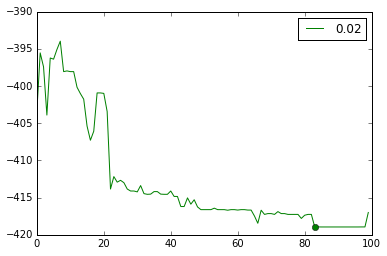

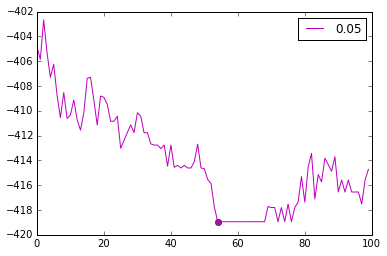

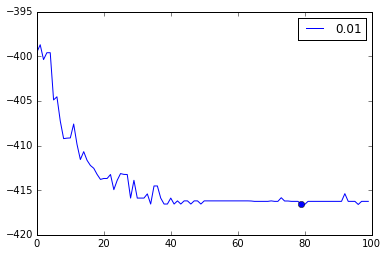

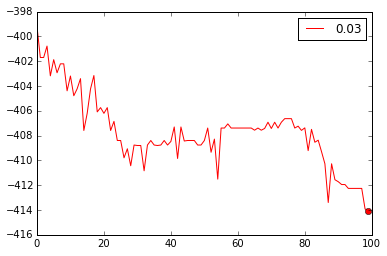

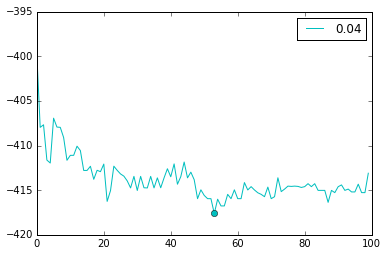

In [102]:
colorGenerator = cycle('bgrcmk') # Keep cycling between these colors for the plots
pltHandles=[]#store legend data to show in final plot

baseball = pd.read_table("../data/textbook/baseball.dat",sep='\s+')
#baseball.head()

predictors = baseball.copy()
logsalary = predictors.pop('salary').apply(np.log)

nrows, ncols = predictors.shape

pop_size = 20
iterations = 100
#check 
mutation_rates = np.array(range(1,6))/float(100)

doGenericAlgo(mutation_rates,[pop_size],False,"mutation")



The plots above show the effect of different mutation rates. As before, we do not observe much shift in the lowest AIC value but as the mutation rate increases, we vary the candidate solutions more and thus observe more shifts or "oscillations" in the AIC plot.

The minimum AIC is -408.165893446
The minimum AIC is -416.410144892
The minimum AIC is -418.451061905


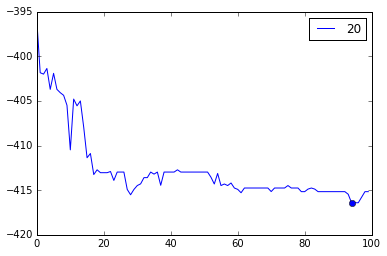

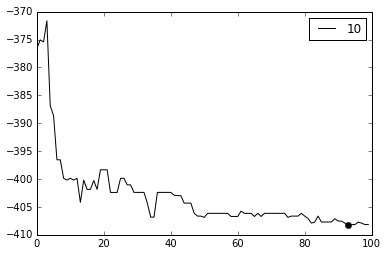

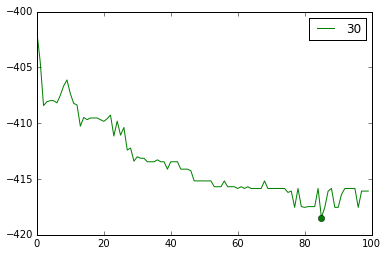

In [107]:
pop_size = [item*10 for item in range(1,4)]
#change pop_size
doGenericAlgo([mutation_rates[0]],pop_size,False,"pop")

We see that a greater population size generally leads to a more stable run of the algorithm. However, on several cases, like the one I chose to plot, all the plots appeared equally stable. The lowest AIC value improves when I increase the population size. This is expected as we can keep track of more number of candidate solutions.

The minimum AIC is -414.487404254
The minimum AIC is -416.603019838


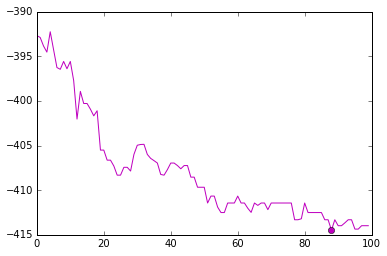

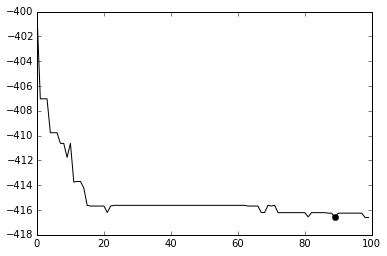

In [109]:
#fitness
pop_size = 20

doGenericAlgo([mutation_rates[0]],[pop_size],False,"fitness")
doGenericAlgo([mutation_rates[0]],[pop_size],True,"fitness")

Of the two plots shown abovem the one on top is when only one parent is eliminated according to fitness and the other is not. We see that that leads to a more gradual progress. However, when both the parents are eliminated aggressively, it causes a sharp drop at a point. However, we do not observe much difference in AIC values over a large number of runs.

## Question 3

Use the combinatorial optimization method of your choice to obtain a solution to the traveling salesman problem for the Brazilian cities 

In [114]:
import math
from copy import deepcopy
from math import hypot

def parse_latlon(x):
    d, m, s = map(float, x.split(':'))
    ms = m/60. + s/3600.
    if d<0:
        return d - ms
    return d + ms

def calculateDistance(cityOrder):
    d=0
    np.append(cityOrder,cityOrder[-1])
    for counter in range(len(cityOrder)-1):#finish when we reach the initial city
        #d+=distanceFromLatLong([cities['lat'][counter],cities['lon'][counter]],[cities['lat'][counter+1],cities['lon'][counter+1]])
        d+=hypot(cities['lat'][cityOrder[counter]]-cities['lat'][cityOrder[counter+1]],cities['lon'][cityOrder[counter]]-cities['lon'][cityOrder[counter+1]])
    return d

def doSimulatedAnnealing(order,coolingSchedule,temperatures):
    #print("inside method")
    iter=0
    #randomly choose two indices to flip
    currentValue = calculateDistance(order)
    for counterTemperature in range(periods):
        for counterStay in range(coolingSchedule[counterTemperature]):
            #propose new solution
            proposedCities = deepcopy(order)
            flips = np.random.choice(26,2,replace=False)
            temp = proposedCities[flips[0]]
            proposedCities[flips[0]] = proposedCities[flips[1]]
            proposedCities[flips[1]] = temp
            #find updated solution
            updatedValue = calculateDistance(proposedCities)
            #find alpha
            alpha = min(1, np.exp((currentValue - updatedValue)/temperatures[counterTemperature]))
            #Accept or Reject?
            if ((updatedValue<currentValue) or (np.random.uniform() < alpha)):
                currentValue=updatedValue
                #print(updatedValue)
                order = proposedCities
    return order,currentValue

cities =  pd.read_csv('../data/brasil_capitals.txt', names=['city','lat','lon'])[['lat','lon']].applymap(parse_latlon)

#define initial solution and order of cities
orderInitials = [np.random.choice(26,26,replace=False) for i in range(20)]#randomly start from 5 different origins
#initialize simulated annealing variables
periods = 30
tempStart=20
temperatures = [tempStart* 0.9**i for i in range(periods)]
coolingSchedule = [50]*int(periods/5) + [100]*int(periods/5) + [150]*int(periods/5) +  [250]*int(periods/5) + [300]*int(periods/5)#spend higher time at lower temperatures
maxIter = sum(coolingSchedule)

distanceBest = 1e15
orderBest = None
for orderInitial in orderInitials:
    #do simulated annealing
    order,distance = doSimulatedAnnealing(orderInitial,coolingSchedule,temperatures)
    if distance<distanceBest:
        distanceBest = distance
        orderBest = order

#append last city. already taken care of while calculating
np.append(order,order[-1])
print(order)
print("The distance is " + str(distance))

[25 24 21 14 11  9  8  7  5 13 16 17 19 18 22 23 20 15 10 12  4  0  1  2  3
  6]
The distance is 137.52680975304554


## Question 4

1) Using a normal approximation to the posterior density, compute the probability that the coin is biased toward heads

In [118]:
from scipy.stats import norm
from scipy.special import betaln
from scipy.optimize import fmin_bfgs


def posterior(theta,y,n):
    post=0
    post += (y*theta - n*(np.log(1+np.exp(theta))) - ((theta-mu)**2)/(2.*sigmaSq))
    return post

#betabin_trans((10, -7.5), cancer.n, cancer.y)
posteriorMin = lambda *args: -posterior(*args)

mu=0
sigmaSq = 0.25
initValue = (0.1)
opt = fmin_bfgs(posteriorMin,initValue,args=(5,5), full_output=True)

mode, var = opt[0], opt[3]

#P(theta>0) = 1 - P(theta<0) = 1 - cdf
probPosBiased = 1 - norm.cdf(0,mode,var)
print("probability that the coin is biased toward heads is  = " +str(probPosBiased[0]))

Optimization terminated successfully.
         Current function value: 2.869167
         Iterations: 3
         Function evaluations: 15
         Gradient evaluations: 5
probability that the coin is biased toward heads is  = [ 0.99340047]


2) We use our prior density $N(0,.25)$ as a proposal density to create a rejection algorithm for sampling from the posterior distribution

In [116]:
def posterior(theta,y,n):
    post = (y*theta - n*(np.log(1+np.exp(theta))) - ((theta-mu)**2)/(2.*sigmaSq))
    return post

def calcDiff(theta, y, n):
    return posterior(theta, y, n) - norm.logpdf(theta,0,0.25)

def reject(mu, sigmaSq, c, nSamples):
    #k = len(mode)
    # Draw samples from g(theta): The proposal distribution
    theta = norm.rvs(mu,sigmaSq,size=nSamples)
    # Calculate probability under g(theta)
    gvals = np.array([norm.logpdf(t,mu,sigmaSq) for t in theta])
    # Calculate probability under f(theta)
    fvals = np.array([posterior(t,5,5) for t in theta])
    # Calculate acceptance probability
    p = np.exp(fvals - gvals + c)
    return theta[np.random.random(nSamples) < p]

calc_diff_min = lambda *args: -calcDiff(*args)

posteriorMin = lambda *args: -posterior(*args)

#define variables for proposal density
mu=0
sigmaSq = 0.25

opt = fmin_bfgs(calc_diff_min,(0.6),args=(5,5),full_output=True)
c = opt[1]
# print(c)

nSamples = 10000
sample = reject(mu,sigmaSq,c,nSamples)
prob = len([element for element in sample if element > 0])/len(sample)
print("probability that the coin is biased toward heads is " + str(prob))

         Current function value: 0.494796
         Iterations: 0
         Function evaluations: 58
         Gradient evaluations: 17
Probability of heads is 0.8340486409155937


3) Using the prior density $N(0,.25)$ as a proposal density, simulate values from the posterior distribution using the SIR algorithm

In [120]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

posterior = lambda theta, y, n : (y*theta - n*(np.log(1+np.exp(theta))) - ((theta-mu)**2)/(2.*sigmaSq))

y = 5
n = 5
mu = 0
sigmaSq = 0.25

#draw samples from the proposal
samples = norm.rvs(mu,sigmaSq,size=10000)

#probabilty under proposal density
qTheta = np.array([norm.logpdf(t,mu,sigmaSq) for t in samples])

#probabilty under posterior
fTheta = np.array([posterior(t,y,n) for t in samples])

#find the weights
w = np.exp(fTheta - qTheta - max(fTheta - qTheta))

#convert the weights to probabilities
weightProb = w/sum(w)

#use updated weights to sample
samplesUpdated = samples[np.random.choice(range(len(samples)),size=10000, p=weightProb)]

#calculate probability of heads
probHeads = len([element for element in samplesUpdated if element>0])/len(samplesUpdated)
print("probability that the coin is biased toward heads is " +str(probHeads))

probability that the coin is biased toward heads is 0.8578
